In [3]:
# https://stackoverflow.com/questions/34478398/import-local-function-from-a-module-housed-in-another-directory-with-relative-im

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from common.utils import get_data_urls, fetch_data, get_labeled_files

In [4]:
#data_urls = get_data_urls()
#fetch_data(data_urls)

data_files, class_labels = get_labeled_files()

In [5]:
from sklearn.model_selection import train_test_split

train_files, test_files, y_train, y_test = train_test_split(data_files, class_labels,
                                                            test_size=0.2, random_state=44)
print(f"Training set size is\t {len(train_files)}")
print(f"Test set size is\t {len(test_files)}")

Training set size is	 7479
Test set size is	 1870


In [6]:
from mailparser import mailparser
from common.message import Message

messages = []
for i, message in enumerate(train_files[:100]):
    messages.append(Message(mailparser.parse_from_file(message), y_train[i]))

Email content 'ms-tnef' not handled
Email content 'pgp-signature' not handled
Email content 'pgp-signature' not handled


In [6]:
#from common.database_populator import DatabasePopulator

#db_populator = DatabasePopulator("../db/spam.db")

In [7]:
#db_populator.populate_message_table(messages)

In [12]:
from common.message import Message
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

import pandas as pd

class MessageTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, input="filename"):
        '''string {‘filename’, ‘file’, ‘content’}, '''
        self.input = input
        self.messages = []
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        '''X is a list of files'''
        feature_aggregator = []
        if isinstance(X, str):
             raise ValueError("Must be a list or iterable, not a string")
        for x in X:
            if self.input == "content":
                mailparser_obj = mailparser.parse_from_string(x)
            elif self.input == "file":
                mailparser_obj = mailparser.parse_from_file_obj(x)
            elif self.input == "filename":
                mailparser_obj = mailparser.parse_from_file(x)
            
            feature_aggregator.append(Message(mailparser_obj, None).extract_features())
            
        return pd.DataFrame.from_records(feature_aggregator)


pipeline = Pipeline([
    ("message_trf", MessageTransformer()),
    ("vectorizer", 
         ColumnTransformer([
            ("tdidf_body_vectorizer", TfidfVectorizer(max_features=1000), "body_tokens"),
         ])
    )
])

In [13]:
test = pipeline.fit_transform(train_files[:100], y_train[:100])

Email content 'ms-tnef' not handled
Email content 'pgp-signature' not handled
Email content 'pgp-signature' not handled


In [21]:
import xgboost as xgb
from sklearn.naive_bayes import MultinomialNB
#xgb.XGBClassifier()
xgb_clf = xgb.XGBClassifier(booster="gblinear").fit(test, y_train[:100])
#naive_clf = MultinomialNB().fit(test, y_train[:400])

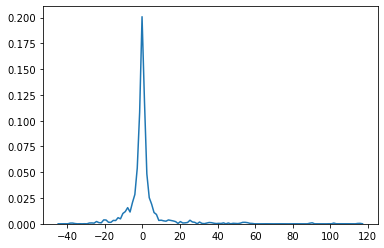

In [24]:
import seaborn as sns
sns.kdeplot(xgb_clf.coef_)

In [82]:
import numpy as np

from sklearn.model_selection import cross_val_score

xgb_train_accuracy = np.mean(cross_val_score(xgb_clf, test, y_train[:400], cv=5))
naive_train_accuracy = np.mean(cross_val_score(naive_clf, test, y_train[:400], cv=5))

In [85]:
len(train_files)

7483

In [83]:
print("XGB Accuracy:\t", xgb_train_accuracy)
print("Naive Bayes Accuracy:\t", naive_train_accuracy)

XGB Accuracy:	 0.9199999999999999
Naive Bayes Accuracy:	 0.9349999999999999


In [723]:
import joblib

joblib.dump(vectorizer, "vectorizer.pkl")

['vectorizer.pkl']